<a href="https://colab.research.google.com/github/iamgarvit/rf-detr-nano/blob/main/rf_detr_nano_vid_inf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Aug  6 08:30:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install -q rfdetr==1.2.1 supervision==0.26.1 roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import shutil

shutil.rmtree("/content/ship-2-cleaned", ignore_errors=True)
shutil.rmtree("/content/ship-2", ignore_errors=True)
print("Deleted previous ship-2-cleaned folder.")

Deleted previous ship-2-cleaned folder.


In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="9yiQAKonTPNoXKbKHsQi")
project = rf.workspace("ship-bism2").project("ship-wbpye")
version = project.version(2)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ship-2 in coco:: 100%|██████████| 19139/19139 [00:11<00:00, 1616.24it/s]


In [7]:
import json
import os
from shutil import copyfile

datasetDir = "/content/ship-2"
outputDir = "/content/ship-2-cleaned"
os.makedirs(outputDir, exist_ok=True)

allowedClasses = ["buoy", "container", "cruise", "fish-b", "warship"]

for split in ["train", "valid", "test"]:
    splitInput = os.path.join(datasetDir, split, "_annotations.coco.json")
    splitOutput = os.path.join(outputDir, split)
    os.makedirs(splitOutput, exist_ok=True)

    with open(splitInput) as f:
        data = json.load(f)

    classMap = {name: idx for idx, name in enumerate(allowedClasses)}

    filteredCategories = []
    oldToNewId = {}
    for cat in data["categories"]:
        if cat["name"] in classMap:
            newId = classMap[cat["name"]]
            oldToNewId[cat["id"]] = newId
            filteredCategories.append({
                "id": newId,
                "name": cat["name"],
                "supercategory": cat.get("supercategory", "")
            })
    data["categories"] = filteredCategories

    filteredAnnotations = []
    validImageIds = set()
    for ann in data["annotations"]:
        if ann["category_id"] in oldToNewId:
            ann["category_id"] = oldToNewId[ann["category_id"]]
            filteredAnnotations.append(ann)
            validImageIds.add(ann["image_id"])
    data["annotations"] = filteredAnnotations

    data["images"] = [img for img in data["images"] if img["id"] in validImageIds]
    with open(os.path.join(splitOutput, "_annotations.coco.json"), "w") as f:
        json.dump(data, f)

    for img in data["images"]:
        srcPath = os.path.join(datasetDir, split, img["file_name"])
        dstPath = os.path.join(splitOutput, img["file_name"])
        if os.path.exists(srcPath):
            copyfile(srcPath, dstPath)

print("Pre-processing complete.")

Pre-processing complete.


In [8]:
print("\nVerifying cleaned category IDs in each split:")
for split in ["train", "valid", "test"]:
    splitAnnPath = os.path.join(outputDir, split, "_annotations.coco.json")
    if not os.path.exists(splitAnnPath):
        print(f"Annotation file not found for split '{split}'")
        continue

    with open(splitAnnPath) as f:
        cleanedData = json.load(f)

    catIds = {cat["id"]: cat["name"] for cat in cleanedData["categories"]}
    print(f"\n Split: {split}")
    for cid, name in sorted(catIds.items()):
        print(f"  ID: {cid} → {name}")



Verifying cleaned category IDs in each split:

 Split: train
  ID: 0 → buoy
  ID: 1 → container
  ID: 2 → cruise
  ID: 3 → fish-b
  ID: 4 → warship

 Split: valid
  ID: 0 → buoy
  ID: 1 → container
  ID: 2 → cruise
  ID: 3 → fish-b
  ID: 4 → warship

 Split: test
  ID: 0 → buoy
  ID: 1 → container
  ID: 2 → cruise
  ID: 3 → fish-b
  ID: 4 → warship


In [9]:
from rfdetr import RFDETRNano

model = RFDETRNano()

model.train(dataset_dir="/content/ship-2-cleaned", epochs=5, batch_size=4, grad_accum_steps=4, lr=1e-4)

rf-detr-nano.pth: 100%|██████████| 349M/349M [00:05<00:00, 68.8MiB/s]


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing your detection head with 5 classes.


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=5, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=5, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-nano.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=2, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, ca_nheads=16

Epoch: [0]  [  0/450]  eta: 0:49:24  lr: 0.000100  class_error: 67.31  loss: 7.1984 (7.1984)  loss_ce: 1.2856 (1.2856)  loss_bbox: 0.6249 (0.6249)  loss_giou: 0.3078 (0.3078)  loss_ce_0: 1.2516 (1.2516)  loss_bbox_0: 0.8537 (0.8537)  loss_giou_0: 0.3856 (0.3856)  loss_ce_enc: 1.2340 (1.2340)  loss_bbox_enc: 0.8422 (0.8422)  loss_giou_enc: 0.4130 (0.4130)  loss_ce_unscaled: 1.2856 (1.2856)  class_error_unscaled: 67.3077 (67.3077)  loss_bbox_unscaled: 0.1250 (0.1250)  loss_giou_unscaled: 0.1539 (0.1539)  cardinality_error_unscaled: 3890.5000 (3890.5000)  loss_ce_0_unscaled: 1.2516 (1.2516)  loss_bbox_0_unscaled: 0.1707 (0.1707)  loss_giou_0_unscaled: 0.1928 (0.1928)  cardinality_error_0_unscaled: 3885.2500 (3885.2500)  loss_ce_enc_unscaled: 1.2340 (1.2340)  loss_bbox_enc_unscaled: 0.1684 (0.1684)  loss_giou_enc_unscaled: 0.2065 (0.2065)  cardinality_error_enc_unscaled: 3464.2500 (3464.2500)  time: 6.5869  data: 1.0612  max mem: 2701
Epoch: [0]  [ 10/450]  eta: 0:19:39  lr: 0.000100  clas

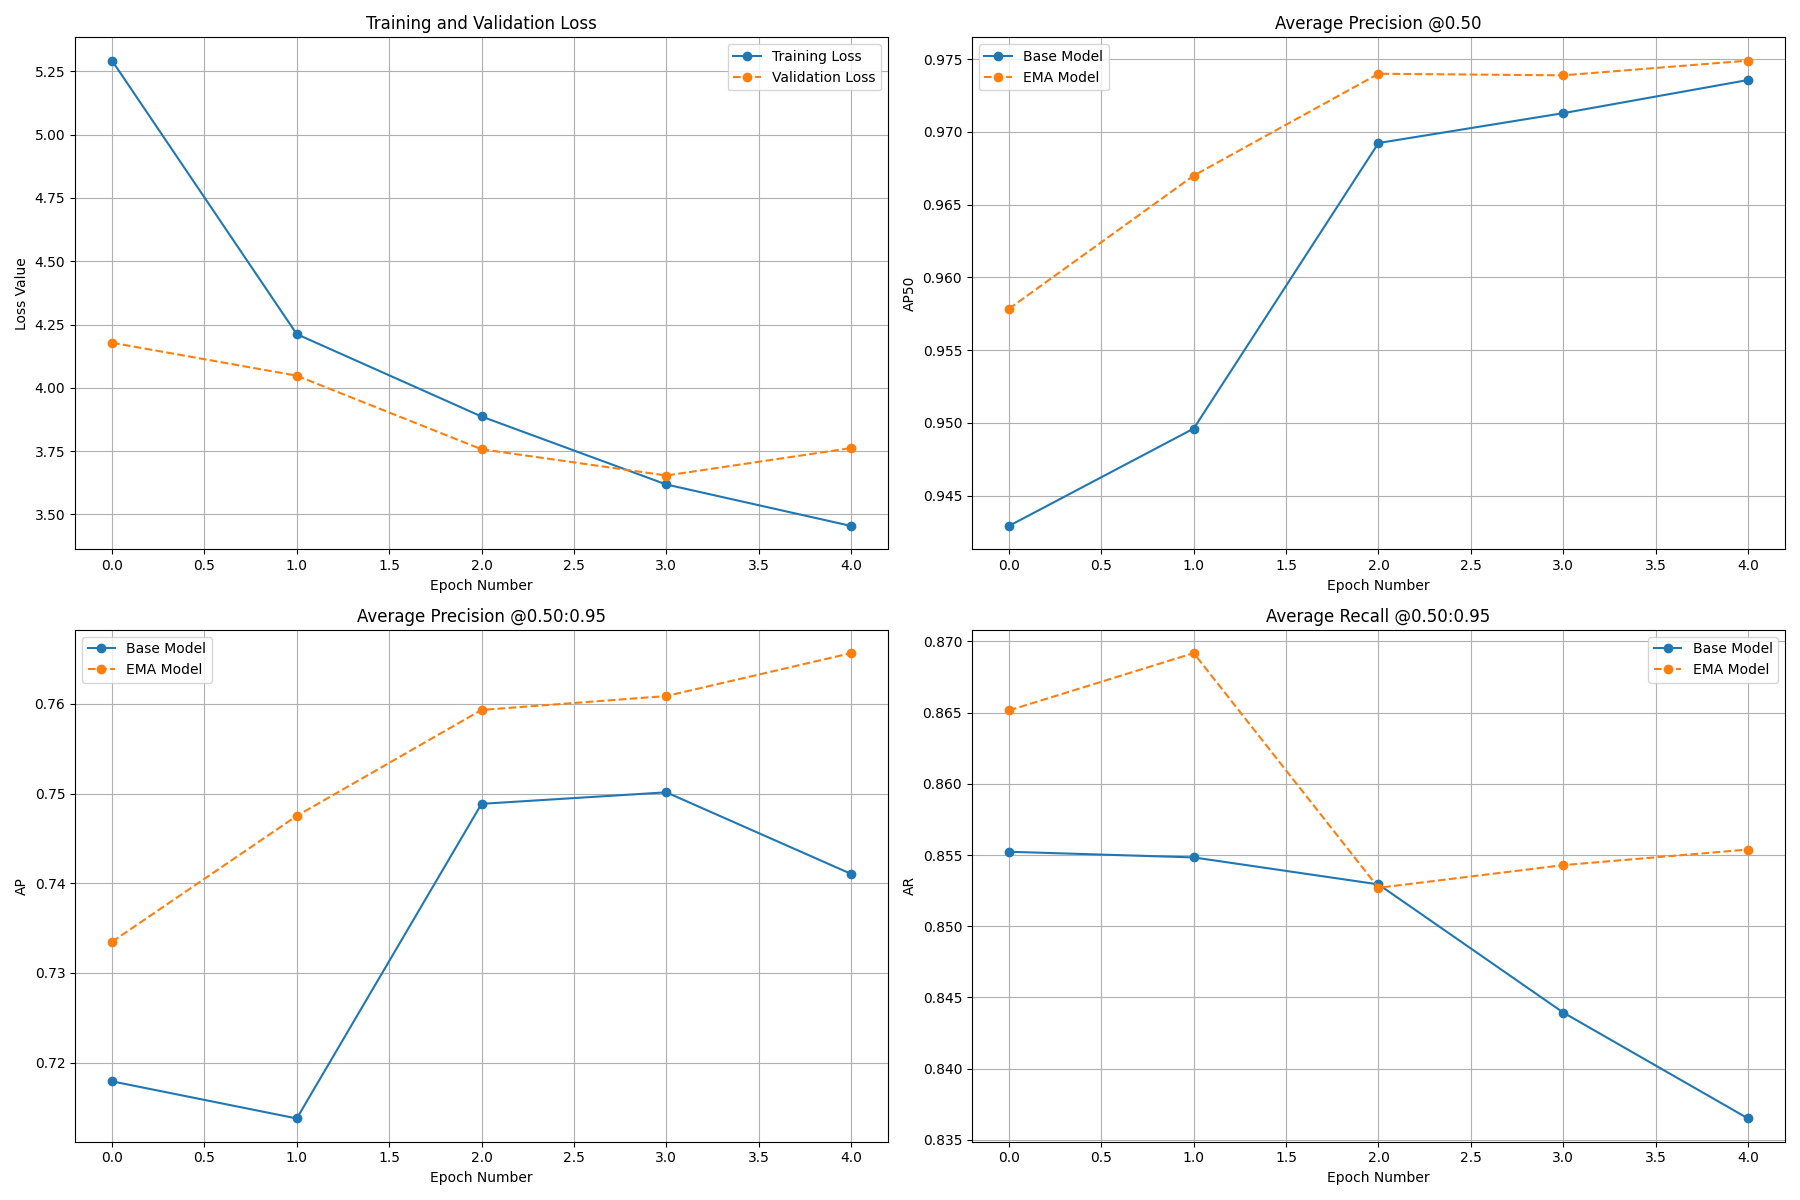

In [10]:
from PIL import Image
Image.open("/content/output/metrics_plot.png")

In [ ]:
#import torch

#torch.save(model.model.model.state_dict(), "rf_detr_medium_weights.pth")
#from google.colab import files
#files.download("rf_detr_medium_weights.pth")

In [11]:
import supervision as sv

dataset_path = "/content/ship-2-cleaned"

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset_path}/test",
    annotations_path=f"{dataset_path}/test/_annotations.coco.json",
)

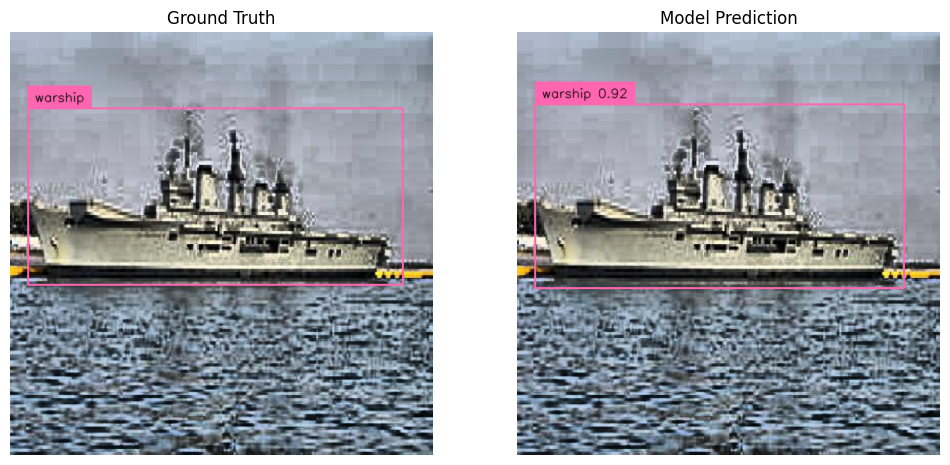

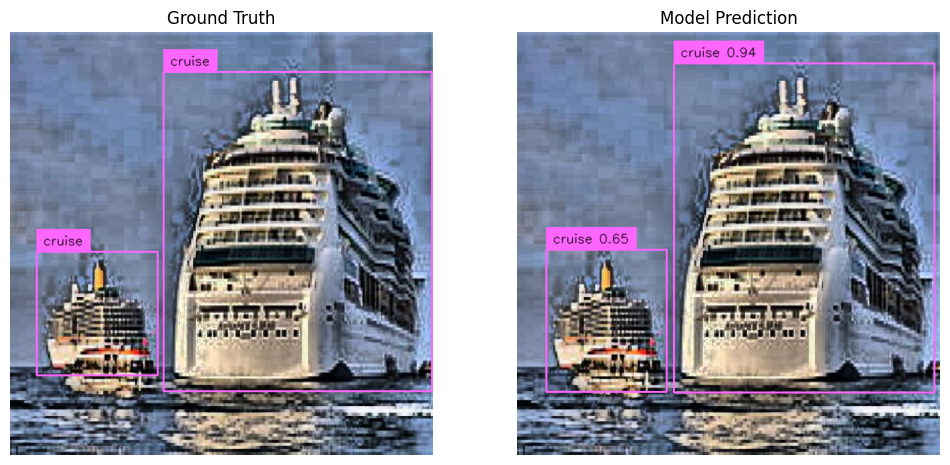

In [12]:
from PIL import Image
import supervision as sv

for i in range(2):
    path, image, annotations = ds[i]
    image = Image.open(path)

    detections = model.predict(image, threshold=0.5)

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
    color = sv.ColorPalette.from_hex([
        "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
        "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
    ])

    bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        color=color,
        text_color=sv.Color.BLACK,
        text_scale=text_scale)

    annotations_labels = [
        f"{ds.classes[class_id]}"
        for class_id in annotations.class_id
    ]

    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence in zip(detections.class_id, detections.confidence)
    ]

    annotation_image = image.copy()
    annotation_image = bbox_annotator.annotate(annotation_image, annotations)
    annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    sv.plot_images_grid(
        images=[annotation_image, detections_image],
        grid_size=(1, 2),
        titles=["Ground Truth", "Model Prediction"]
    )

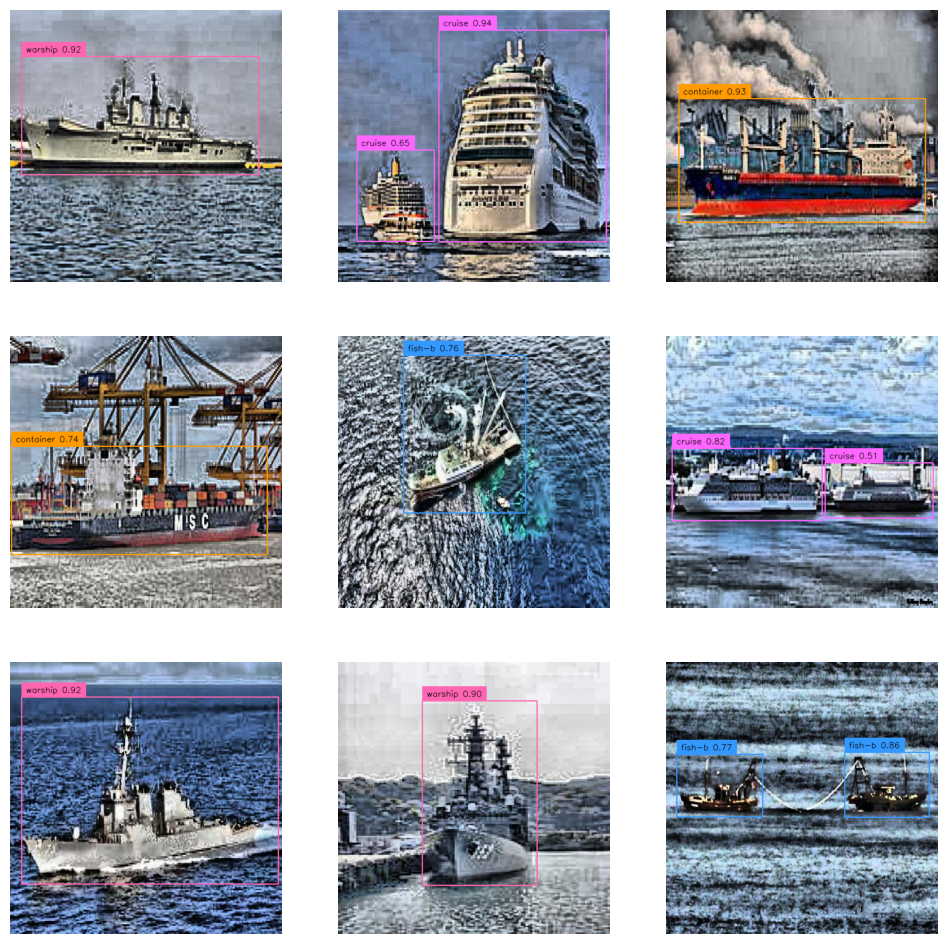

In [13]:
detections_images = []

for i in range(9):
    path, image, annotations = ds[i]
    image = Image.open(path)

    detections = model.predict(image, threshold=0.5)

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
    color = sv.ColorPalette.from_hex([
        "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
        "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
    ])

    bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        color=color,
        text_color=sv.Color.BLACK,
        text_scale=text_scale)

    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    detections_images.append(detections_image)

sv.plot_images_grid(images=detections_images, grid_size=(3, 3), size=(12, 12))

In [14]:
import supervision as sv
from tqdm import tqdm

CUSTOM_CLASSES = ['buoy', 'container', 'cruise', 'fish-b', 'warship']
SOURCE_VIDEO_PATH = "/content/198982-909251580_small.mp4"
TARGET_VIDEO_PATH = "/content/output_video.mp4"

frameGenerator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
videoInfo = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

with sv.VideoSink(TARGET_VIDEO_PATH, videoInfo) as sink:
    for frame in tqdm(frameGenerator, desc="Processing video"):
        detections = model.predict(frame, threshold=0.5, iou=0.1)
        labels = [CUSTOM_CLASSES[classId] if 0 <= classId < len(CUSTOM_CLASSES) else str(classId)
                  for classId in detections.class_id]
        annotatedFrame = frame.copy()
        annotatedFrame = sv.BoxAnnotator().annotate(scene=annotatedFrame, detections=detections)

        annotatedFrame = sv.LabelAnnotator(text_thickness=2).annotate(
            scene=annotatedFrame,
            detections=detections,
            labels=labels
        )
        sink.write_frame(annotatedFrame)

print(f"\nVideo processing complete. Output saved to: {TARGET_VIDEO_PATH}")

Processing video: 1687it [02:26, 11.50it/s]


Video processing complete. Output saved to: /content/output_video.mp4


In [15]:
import supervision as sv
from tqdm import tqdm

CUSTOM_CLASSES = ['buoy', 'container', 'cruise', 'fish-b', 'warship']

SOURCE_VIDEO_PATH = "/content/warship.mp4"
TARGET_VIDEO_PATH = "/content/warship_output.mp4"

frameGenerator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
videoInfo = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

with sv.VideoSink(TARGET_VIDEO_PATH, videoInfo) as sink:
    for frame in tqdm(frameGenerator, desc="Processing video"):
        detections = model.predict(frame, threshold=0.5, iou=0.1)

        labels = [CUSTOM_CLASSES[classId] if 0 <= classId < len(CUSTOM_CLASSES) else str(classId)
                  for classId in detections.class_id]

        annotatedFrame = frame.copy()
        annotatedFrame = sv.BoxAnnotator().annotate(scene=annotatedFrame, detections=detections)

        annotatedFrame = sv.LabelAnnotator(text_thickness=2).annotate(
            scene=annotatedFrame,
            detections=detections,
            labels=labels
        )

        sink.write_frame(annotatedFrame)

print(f"\nVideo processing complete. Output saved to: {TARGET_VIDEO_PATH}")

Processing video: 232it [00:23,  9.99it/s]


Video processing complete. Output saved to: /content/warship_output.mp4


In [16]:
import supervision as sv
from tqdm import tqdm

CUSTOM_CLASSES = ['buoy', 'container', 'cruise', 'fish-b', 'warship']

SOURCE_VIDEO_PATH = "/content/container.mp4"
TARGET_VIDEO_PATH = "/content/container_output.mp4"

frameGenerator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
videoInfo = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

with sv.VideoSink(TARGET_VIDEO_PATH, videoInfo) as sink:
    for frame in tqdm(frameGenerator, desc="Processing video"):
        detections = model.predict(frame, threshold=0.5, iou=0.1)

        labels = [CUSTOM_CLASSES[classId] if 0 <= classId < len(CUSTOM_CLASSES) else str(classId)
                  for classId in detections.class_id]

        annotatedFrame = frame.copy()
        annotatedFrame = sv.BoxAnnotator().annotate(scene=annotatedFrame, detections=detections)

        annotatedFrame = sv.LabelAnnotator(text_thickness=2).annotate(
            scene=annotatedFrame,
            detections=detections,
            labels=labels
        )

        sink.write_frame(annotatedFrame)

print(f"\nVideo processing complete. Output saved to: {TARGET_VIDEO_PATH}")

Processing video: 1121it [06:43,  2.78it/s]


Video processing complete. Output saved to: /content/container_output.mp4


In [17]:
import supervision as sv
from tqdm import tqdm

CUSTOM_CLASSES = ['buoy', 'container', 'cruise', 'fish-b', 'warship']

SOURCE_VIDEO_PATH = "/content/boats.mp4"
TARGET_VIDEO_PATH = "/content/boats_output.mp4"

frameGenerator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
videoInfo = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

with sv.VideoSink(TARGET_VIDEO_PATH, videoInfo) as sink:
    for frame in tqdm(frameGenerator, desc="Processing video"):
        detections = model.predict(frame, threshold=0.5, iou=0.1)

        labels = [CUSTOM_CLASSES[classId] if 0 <= classId < len(CUSTOM_CLASSES) else str(classId)
                  for classId in detections.class_id]

        annotatedFrame = frame.copy()
        annotatedFrame = sv.BoxAnnotator().annotate(scene=annotatedFrame, detections=detections)

        annotatedFrame = sv.LabelAnnotator(text_thickness=2).annotate(
            scene=annotatedFrame,
            detections=detections,
            labels=labels
        )

        sink.write_frame(annotatedFrame)

print(f"\nVideo processing complete. Output saved to: {TARGET_VIDEO_PATH}")

Processing video: 625it [00:55, 11.16it/s]


Video processing complete. Output saved to: /content/boats_output.mp4


In [20]:
import torch
torch.save(model.model, "rf_detr_nano_full.pth")

In [23]:
from google.colab import files
files.download("rf_detr_nano_full.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>